<a href="https://colab.research.google.com/github/Anmol42/IDP-sem4/blob/vae/notebooks/GAN_colorize_with_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataloader import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/Copy\ of\ img_align_celeba.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [4]:
from skimage.io import imread_collection
path = "/content/img_align_celeba/10*jpg"
train_ds = imread_collection(path)

In [5]:
from skimage.color import rgb2lab,lab2rgb
from skimage.transform import resize
images= torch.zeros(len(train_ds),3,128,128)
for i,im in enumerate(train_ds):
  im = resize(im, (128,128,3),
                       anti_aliasing=True)
  image = rgb2lab(im)
  image = torch.Tensor(image)
  image = image.permute(2,0,1)
  #print(i)
  images[i]=image
print(images.max(),images.min())
images[:,0] = images[:,0]/100
images[:,1:] = images[:,1:]/128
print(images.max(),images.min())
batch_size = 100

tensor(99.6549) tensor(-107.4650)
tensor(0.9965) tensor(-0.8396)


In [6]:
## generator model
class generator(nn.Module):
    def __init__(self):         # z is input noise
        super(generator,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,8,kernel_size=3,padding=1,stride=2),
                                   nn.BatchNorm2d(8),
        nn.LeakyReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(8,16,kernel_size=5,padding=2,stride=2),
                                   nn.BatchNorm2d(16),
        nn.LeakyReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1,stride=2),
                                   nn.BatchNorm2d(32),
        nn.LeakyReLU())
        self.bottleneck = nn.Sequential(nn.Conv2d(32,32,kernel_size=5,padding=2,stride=2),
        nn.LeakyReLU())
        # BottleNeck
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(34,32,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
        nn.ReLU())
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(8,2,kernel_size=4,stride=2,padding=1),
        nn.Tanh())

    def forward(self,xb,z):
        out1 = self.conv1(xb)
        #print("out1 ",out1.shape)
        out2 = self.conv2(out1)
        #print("out 2",out2.shape)
        out3 = self.conv3(out2)
        #print("out3 ",out3.shape)
        out4 = self.bottleneck(out3)
        #print("after bottleneck",out4.shape)
        out4 = torch.cat((z,out4),1)
        out4 = self.deconv4(out4)
        #print("after deconv4",out4.shape)
        out4 = self.deconv3(out4)
        #print("after deconv3",out4.shape)
        out4 = self.deconv2(out4)
        #print("after deconv2",out4.hape)
        out4 = self.deconv1(out4)
        #print("after deconv1",out4.shape)
        return torch.cat((xb,out4),1)

In [7]:
## discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=4,stride=4),
            nn.ReLU(),
            nn.Conv2d(16,64,kernel_size=4,stride=4),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=4,stride=4),
            nn.ReLU(),
            nn.Conv2d(128,64,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64,16,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(16,4,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(4,1,kernel_size=1),
            nn.Sigmoid(),
            nn.Flatten()
        )
    def forward(self,x):
      return self.network(x)

In [8]:
gen_model = generator()
dis_model = discriminator()

In [9]:
#gen_model(images[:100,0].unsqueeze(1),torch.randn(batch_size,2,16,16))

In [10]:
print(images.shape)

torch.Size([10000, 3, 128, 128])


In [11]:
train_dl = DataLoader(images[:7000],batch_size,shuffle=True,pin_memory=True,num_workers=2)
val_dl = DataLoader(images[7000:9000],batch_size, num_workers=2,pin_memory=True)
test_dl = DataLoader(images[9000:],batch_size,num_workers=2)

In [12]:
norm_ = torch.linalg.norm
bceloss = nn.BCEWithLogitsLoss()
#minimise this # t is whether the image is fake or real; x is prob vect of patches being real/fake.
def loss_inf(x,t):    # probability vector from discriminator as input
    return int(t)*(torch.mean(norm_(1-x))) + (1-int(t))*(torch.mean(norm_(x)))

In [13]:
l1loss = nn.L1Loss()
def gen_loss(x,y):
    return l1loss(x,y)

In [14]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')
test_dl = DeviceDataLoader(test_dl,'cuda')
gen_model.to('cuda')
dis_model.to('cuda')

discriminator(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 64, kernel_size=(4, 4), stride=(4, 4))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(4, 4))
    (5): ReLU()
    (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
    (13): Sigmoid()
    (14): Flatten(start_dim=1, end_dim=-1)
  )
)

In [ ]:
def get_item(batch_size=100):
    pass
import torch.autograd as auto
auto.set_detect_anomaly(True)

In [16]:
def fit(epochs,lr_g,lr_d,generator,discriminator,batch_size,opt_func=torch.optim.Adam):
    gen_optimize = opt_func(generator.parameters(),lr_g)
    dis_optimize = opt_func(discriminator.parameters(),lr_d)
    discriminator.eval()
    train_g_history,train_d_history = [],[]
    val_g_history, val_d_history = [],[]
    for epoch in range(epochs):
        epoch_loss_g = torch.zeros(1).to('cuda')
        epoch_loss_d = torch.zeros(1).to('cuda')
        noise = torch.randn(batch_size,2,8,8).to('cuda')
        for batch in train_dl:
            #t = torch.randint(0,2,(batch_size,)).to('cuda') filhal totally useless
            
            out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
            real_score = discriminator(batch) # how real is the og input image
            fake_score = discriminator(out) # how real is the generated image  
            loss_d = loss_inf(real_score,1) + loss_inf(fake_score,0)# discriminator

            loss_d.backward()
            dis_optimize.zero_grad()
            dis_optimize.step()
            
            out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
            real_score = discriminator(batch) # how real is the og input image
            fake_score = discriminator(out) # how real is the generated image  

            loss_g = 2*gen_loss(out,batch) + loss_inf(fake_score,1)
            loss_g.backward()
            gen_optimize.step()
            gen_optimize.zero_grad()

            with torch.no_grad():
              epoch_loss_g += loss_g
              epoch_loss_d += loss_d
        train_d_history.append(epoch_loss_d)
        train_g_history.append(epoch_loss_g)
        epoch_loss_g = 0
        epoch_loss_d = 0
        for batch in val_dl:
            with torch.no_grad():
              out = generator(batch[:,0].unsqueeze(1),noise) # gives a,b channel for LAB color scheme 
              real_score = discriminator(batch) # how real is the og input image
              fake_score = discriminator(out) # how real is the generated image  
              loss_d = loss_inf(real_score,1) + loss_inf(fake_score,0)# discriminator
              loss_g = 2*gen_loss(out,batch) + loss_inf(fake_score,1)
              epoch_loss_g += loss_g
              epoch_loss_d += loss_d

        
        val_g_history.append(epoch_loss_g)
        val_d_history.append(epoch_loss_d)
        if epoch % 10 == 0:
            print("Gen Epoch Loss",epoch_loss_g)
            print("Discriminator Epoch loss",epoch_loss_d)
    return train_d_history,train_g_history,val_d_history,val_g_history


In [ ]:
loss_h = fit(100,0.001,0.001,gen_model,dis_model,batch_size,opt_func=torch.optim.Adam)

Gen Epoch Loss tensor(391.9049, device='cuda:0')
Discriminator Epoch loss tensor(130.3194, device='cuda:0')
Gen Epoch Loss tensor(114.2711, device='cuda:0')
Discriminator Epoch loss tensor(407.4965, device='cuda:0')
Gen Epoch Loss tensor(110.1265, device='cuda:0')
Discriminator Epoch loss tensor(411.6136, device='cuda:0')
Gen Epoch Loss tensor(110.7009, device='cuda:0')
Discriminator Epoch loss tensor(411.0176, device='cuda:0')


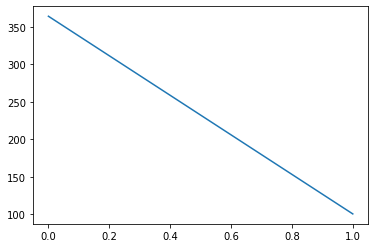

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_h[0])

tensor([[0.4354, 0.4353, 0.4355, 0.4350]], device='cuda:0',
       grad_fn=<ViewBackward>)
torch.Size([3, 128, 128])
(128, 128, 3)


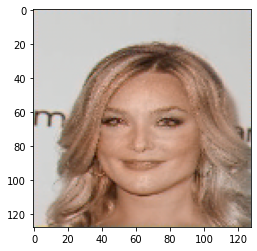

In [ ]:
from skimage.color import rgb2lab,lab2rgb
gen_model.eval()
dis_model.eval()
n = 9069
z = torch.randn(1,2,8,8).to('cuda')
im = images[n][0].unsqueeze(0).unsqueeze(0).to('cuda')
fake = gen_model(im,z)
print(dis_model(fake))

print(fake[0].shape)
fake = fake[0].permute(1,2,0).detach().cpu().numpy()
print(fake.shape)
fake[:,:,0] *=100
fake[:,:,1:] *= 110
fake =lab2rgb(fake)
import matplotlib.pyplot as plt
plt.imshow(fake)

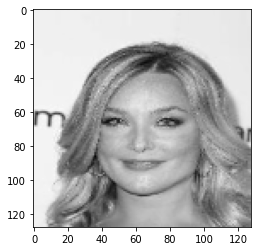

In [ ]:
from skimage.color import rgb2gray
fake = rgb2gray(fake) 
plt.imshow(fake,cmap='gray')

tensor([[0.6089, 0.6089, 0.6089, 0.6088]], device='cuda:0',
       grad_fn=<ViewBackward>)
(128, 128, 3)


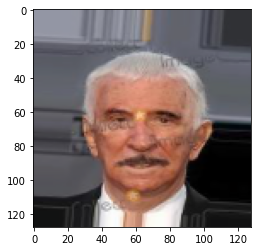

In [19]:
#print(dis_model(images[n].unsqueeze(0).to('cuda')))
real=images[100]
print(dis_model(real.unsqueeze(0).cuda(0)))
real[0] *= 100
real[1:] *= 128
real = real.permute(1,2,0).cpu().detach().numpy()

print(real.shape)
real =lab2rgb(real)
import matplotlib.pyplot as plt
plt.imshow(real)

In [ ]:
torch.save_dict_